## Brainwave Frequencies:
Beta, 14 to 30 Hz.  
Alpha, 8 to 14 Hz.  
Theta, 4 to 8 Hz.  


Generating training data...
Processing session:  data/ML101_KS.csv . ( 1  of  16 )
Interpolating 234/234nterpolating 28/234Interpolating 38/234Interpolating 50/234Interpolating 67/234Interpolating 91/234Interpolating 108/234Interpolating 132/234Interpolating 154/234Interpolating 168/234Interpolating 205/234Interpolating 218/234234  frames generated with label  1 .


Processing session:  data/ML101_US.csv . ( 2  of  16 )
224  frames generated with label  0 .224Interpolating 35/224Interpolating 64/224Interpolating 77/224Interpolating 105/224Interpolating 117/224Interpolating 137/224Interpolating 148/224Interpolating 166/224Interpolating 193/224Interpolating 204/224Interpolating 213/224


Processing session:  data/ML102_KS.csv . ( 3  of  16 )
222  frames generated with label  1 .222Interpolating 101/222Interpolating 131/222Interpolating 147/222Interpolating 167/222Interpolating 179/222Interpolating 205/222


Processing session:  data/ML102_US.csv . ( 4  of  16 )
Interpolating 218/218nterp

Text(0.5, 1.0, 'Beta')

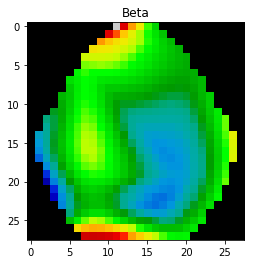

In [1]:
#train_pipeline
#from https://github.com/tevisgehr/EEG-Classification
from eeg_learn_functions import *
import pandas as pd
import numpy as np
import scipy.stats as scs
import re
from numpy import genfromtxt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.display.max_columns = None
pd.options.display.precision = 4

theta = (4,8)
alpha = (8,12)
beta = (12,40)

def get_fft(snippet):
    Fs = 128.0;  # sampling rate
    #Ts = len(snippet)/Fs/Fs; # sampling interval
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector

    # ff = 5;   # frequency of the signal
    # y = np.sin(2*np.pi*ff*t)
    y = snippet
#     print('Ts: ',Ts)
#     print(t)
#     print(y.shape)
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]
    #Added in: (To remove bias.)
    #Y[0] = 0
    return frq,abs(Y)

def theta_alpha_beta_averages(f,Y):
    theta_range = (4,8)
    alpha_range = (8,12)
    beta_range = (12,40)
    theta = Y[(f>theta_range[0]) & (f<=theta_range[1])].mean()
    alpha = Y[(f>alpha_range[0]) & (f<=alpha_range[1])].mean()
    beta = Y[(f>beta_range[0]) & (f<=beta_range[1])].mean()
    return theta, alpha, beta

def make_steps(samples,frame_duration,overlap):
    '''
    in:
    samples - number of samples in the session
    frame_duration - frame duration in seconds
    overlap - float fraction of frame to overlap in range (0,1)

    out: list of tuple ranges
    '''
    #steps = np.arange(0,len(df),frame_length)
    Fs = 128
    i = 0
    intervals = []
    samples_per_frame = Fs * frame_duration
    while i+samples_per_frame <= samples:
        intervals.append((i,i+samples_per_frame))
        i = i + samples_per_frame - int(samples_per_frame*overlap)
    return intervals

def make_frames(df,frame_duration):
    '''
    in: dataframe or array with all channels, frame duration in seconds
    out: array of theta, alpha, beta averages for each probe for each time step
        shape: (n-frames,m-probes,k-brainwave bands)
    '''
    Fs = 128.0
    frame_length = Fs*frame_duration
    frames = []
    steps = make_steps(len(df),frame_duration,overlap)
    for i,_ in enumerate(steps):
        frame = []
        if i == 0:
            continue
        else:
            for channel in df.columns:
                snippet = np.array(df.loc[steps[i][0]:steps[i][1],int(channel)])
                f,Y =  get_fft(snippet)
                theta, alpha, beta = theta_alpha_beta_averages(f,Y)
                frame.append([theta, alpha, beta])

        frames.append(frame)
    return np.array(frames)

locs_2d = [(-2.0,4.0),
           (2.0,4.0),
           (-1.0,3.0),
           (1.0,3.0),
           (-3.0,3.0),
           (3.0,3.0),
           (-2.0,2.0),
           (2.0,2.0),
           (-2.0,-2.0),
           (2.0,-2.0),
           (-4.0,1.0),
           (4.0,1.0),
           (-1.0,-3.0),
           (1.0,-3.0)]

def make_data_pipeline(file_names,labels,image_size,frame_duration,overlap):
    '''
    IN:
    file_names - list of strings for each input file (one for each subject)
    labels - list of labels for each
    image_size - int size of output images in form (x, x)
    frame_duration - time length of each frame (seconds)
    overlap - float fraction of frame to overlap in range (0,1)

    OUT:
    X: np array of frames (unshuffled)
    y: np array of label for each frame (1 or 0)
    '''

    Fs = 128.0   #sampling rate
    frame_length = Fs * frame_duration

    print('Generating training data...')


    for i, file in enumerate(file_names):
        print ('Processing session: ',file, '. (',i+1,' of ',len(file_names),')')
        data = genfromtxt(file, delimiter=',').T
        df = pd.DataFrame(data)

        X_0 = make_frames(df,frame_duration)
        #steps = np.arange(0,len(df),frame_length)
        X_1 = X_0.reshape(len(X_0),14*3)

        images = gen_images(np.array(locs_2d),X_1, image_size, normalize=False)
        images = np.swapaxes(images, 1, 3)
        print(len(images), ' frames generated with label ', labels[i], '.')
        print('\n')
        if i == 0:
            X = images
            y = np.ones(len(images))*labels[0]
        else:
            X = np.concatenate((X,images),axis = 0)
            y = np.concatenate((y,np.ones(len(images))*labels[i]),axis = 0)


    return X,np.array(y)

file_names = ['data/ML101_KS.csv',
              'data/ML101_US.csv',
              'data/ML102_KS.csv',
              'data/ML102_US.csv',
              'data/ML103_KS.csv',
              'data/ML103_US.csv',
              'data/ML104_KS.csv',
              'data/ML104_US.csv',
              'data/ML105_KS.csv',
              'data/ML105_US.csv',
              'data/ML106_KS.csv',
              'data/ML106_US.csv',
              'data/ML107_KS.csv',
              'data/ML107_US.csv',
              'data/ML108_KS.csv',
              'data/ML108_US.csv']
labels = [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]
image_size = 28
frame_duration = 1.0
overlap = 0.5
X, y = make_data_pipeline(file_names,labels,image_size,frame_duration,overlap)






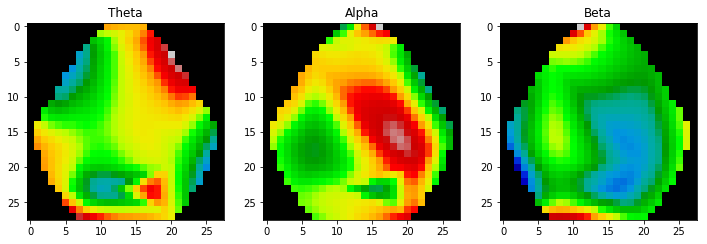

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
f, axarr = plt.subplots(1,3, figsize = (12,8))
axarr[0].set_title('Theta')
axarr[0].imshow(X[0][:,:,0], cmap='nipy_spectral')
axarr[1].set_title('Alpha')
axarr[1].imshow(X[0][:,:,1], cmap='nipy_spectral')
axarr[2].set_title('Beta')
axarr[2].imshow(X[0][:,:,2], cmap='nipy_spectral')


In [2]:

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20,shuffle=True)

# input image dimensions
img_rows, img_cols = 28, 28

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = (img_rows, img_cols, 3)

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

batch_size = 128
num_classes = 2
epochs = 500

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)


model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255


model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

x_train shape: (2913, 28, 28, 3)
2913 train samples
729 test samples


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 2913 samples, validate on 729 samples
Epoch 1/500
2913/2913 [==============================] - 11s 4ms/step - loss: 0.7029 - accuracy: 0.5101 - val_loss: 0.6911 - val_accuracy: 0.4979
Epoch 2/500
2913/2913 [==============================] - 9s 3ms/step - loss: 0.6908 - accuracy: 0.5290 - val_loss: 0.6913 - val_accuracy: 0.5309
Epoch 3/500
2913/2913 [==============================] - 7s 2ms/step - loss: 0.6884 - accuracy: 0.5221 - val_loss: 0.6911 - val_accuracy: 0.5350
Epoch 4/500
2913/2913 [==============================] - 7s 2ms/step - loss: 0.6875 - accuracy: 0.5129 - val_loss: 0.6929 - val_accuracy: 0.4856
Epoch 5/500
2913/2913 [==============================] - 9s 3ms/step - loss: 0.6862 - accuracy: 0.5239 - val_loss: 0.6959 - val_accuracy: 0.5048
Epoch 6/500
2913/2913 [==============================] - 8s 3ms/step - loss: 0.6854 - accuracy: 0.5331 - va

Epoch 53/500
2913/2913 [==============================] - 10s 3ms/step - loss: 0.5014 - accuracy: 0.7456 - val_loss: 0.6097 - val_accuracy: 0.6763
Epoch 54/500
2913/2913 [==============================] - 8s 3ms/step - loss: 0.5118 - accuracy: 0.7315 - val_loss: 0.6158 - val_accuracy: 0.6818
Epoch 55/500
2913/2913 [==============================] - 8s 3ms/step - loss: 0.4919 - accuracy: 0.7446 - val_loss: 0.6143 - val_accuracy: 0.6612
Epoch 56/500
2913/2913 [==============================] - 8s 3ms/step - loss: 0.4924 - accuracy: 0.7432 - val_loss: 0.5759 - val_accuracy: 0.6982
Epoch 57/500
2913/2913 [==============================] - 9s 3ms/step - loss: 0.4897 - accuracy: 0.7535 - val_loss: 0.5691 - val_accuracy: 0.6968
Epoch 58/500
2913/2913 [==============================] - 9s 3ms/step - loss: 0.4916 - accuracy: 0.7545 - val_loss: 0.5835 - val_accuracy: 0.6982
Epoch 59/500
2913/2913 [==============================] - 9s 3ms/step - loss: 0.4721 - accuracy: 0.7590 - val_loss: 0.6011 

KeyboardInterrupt: 

In [ ]:
# extract weather data
import openweather
from datetime import datetime

# create client
ow = openweather.OpenWeather('afdc65050f1cdb2774c23cf50f0330c9')

# find weather stations near me
stations = ow.find_stations_near(
    7.0,  # longitude
    50.0, # latitude
    100   # kilometer radius
)

# iterate results
for station in stations:
    print (station)

# get current weather at Cologne/Bonn airport
# (station id = 4885)
print (ow.get_weather(4885))

# historic weather
start_date = datetime(2013, 09, 10)
end_date = datetime(2013, 09, 15)

# default: hourly interval
print ow.get_historic_weather(4885, start_date, end_date)

# daily aggregates
print ow.get_historic_weather(4885, start_date, end_date, "day")

In [ ]:
# XGBOOST classifier
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X_1 = LabelEncoder()
X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1])
labelencoder_X_2 = LabelEncoder()
X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])
onehotencoder = OneHotEncoder(categorical_features = [1])
X = onehotencoder.fit_transform(X).toarray()
X = X[:, 1:]

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Fitting XGBoost to the Training set
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
accuracies.mean()
accuracies.std()